In [11]:
import torch
from torch.utils.tensorboard import SummaryWriter

from data import artificial_1D_linear as data
from utils.general import get_logging_dir
from experiments.artificial_1D_linear.documentation import (
    evaluate,
    plot_data_split,
    plot_predictions,
)
from models import SmartAverageLayer

from experiments.artificial_1D_linear.smart_fed_avg_util import (
    train_client,
    register_client_test_losses,
)

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
NUM_CLIENTS = 2

COMMUNICATION_ROUNDS = 10
CLIENT_EPOCHS = 100

SPLIT_TYPE = "random"

In [14]:
CLIENT_IDs = range(NUM_CLIENTS)

BATCH_SIZE = 64

INPUT_FEATURES = 1
OUTPUT_FEATURES = 1
ARCHITECTURE = [11, 12, 11, 12]

LOSS_FN = torch.nn.MSELoss()

In [15]:
def register_hyperparameters(writer, last_loss):
    writer.add_hparams(
        {
            "client_epochs": CLIENT_EPOCHS,
            "num_clients": NUM_CLIENTS,
            "communication_rounds": COMMUNICATION_ROUNDS,
            "split_type": SPLIT_TYPE,
            "architecture": str(ARCHITECTURE),
        },
        {
            "MSE Test": last_loss,
        },
        run_name=".",
    )

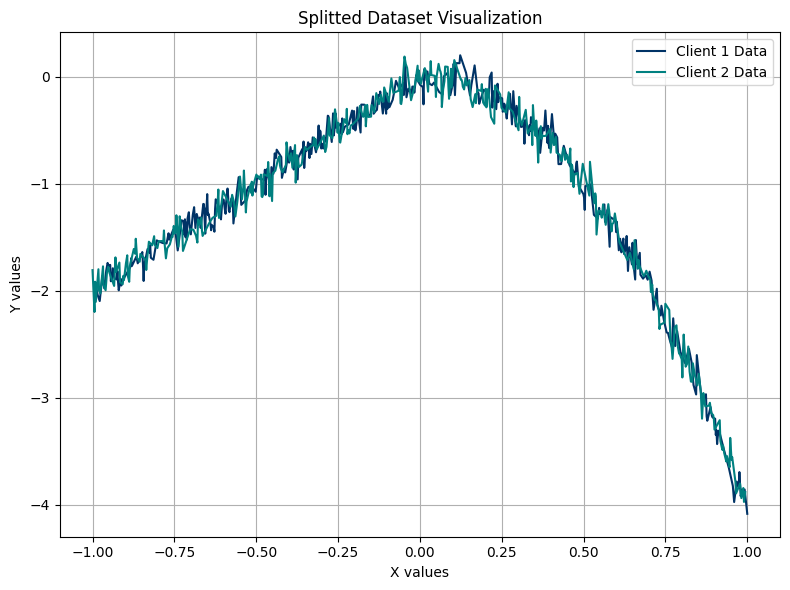

In [16]:
model_name = f"MyFed_{NUM_CLIENTS}clients_{SPLIT_TYPE}-split"
writer = SummaryWriter(get_logging_dir(model_name, "artificial_1D_linear"))

clients = [
    SmartAverageLayer.initialize_from_scratch(INPUT_FEATURES, OUTPUT_FEATURES, NUM_CLIENTS, client_id, ARCHITECTURE)
    for client_id in CLIENT_IDs
]

client_train_dataloaders = data.get_client_train_dataloaders(
    NUM_CLIENTS, SPLIT_TYPE, BATCH_SIZE, shuffle=True
)

plot_data_split(client_train_dataloaders, writer)

In [17]:
print(clients[0])

SmartAverageLayer(
  (prediction_network): MultiOutputNet(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=2, out_features=11, bias=False)
      (1): Linear(in_features=12, out_features=12, bias=False)
      (2): Linear(in_features=13, out_features=11, bias=False)
      (3): Linear(in_features=12, out_features=12, bias=False)
    )
    (output_layers): ModuleList(
      (0-1): 2 x Linear(in_features=13, out_features=1, bias=False)
    )
    (output_scalings): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1]
        (1): Parameter containing: [torch.float32 of size 1]
    )
  )
)


Communication Round 9/10
 global model:  SmartAverageLayer(
  (prediction_network): MultiOutputNet(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=2, out_features=16, bias=False)
      (1): Linear(in_features=17, out_features=23, bias=False)
      (2): Linear(in_features=24, out_features=20, bias=False)
      (3): Linear(in_features=21, out_features=27, bias=False)
    )
    (output_layers): ModuleList(
      (0-1): 2 x Linear(in_features=28, out_features=1, bias=False)
    )
    (output_scalings): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1]
        (1): Parameter containing: [torch.float32 of size 1]
    )
  )
)

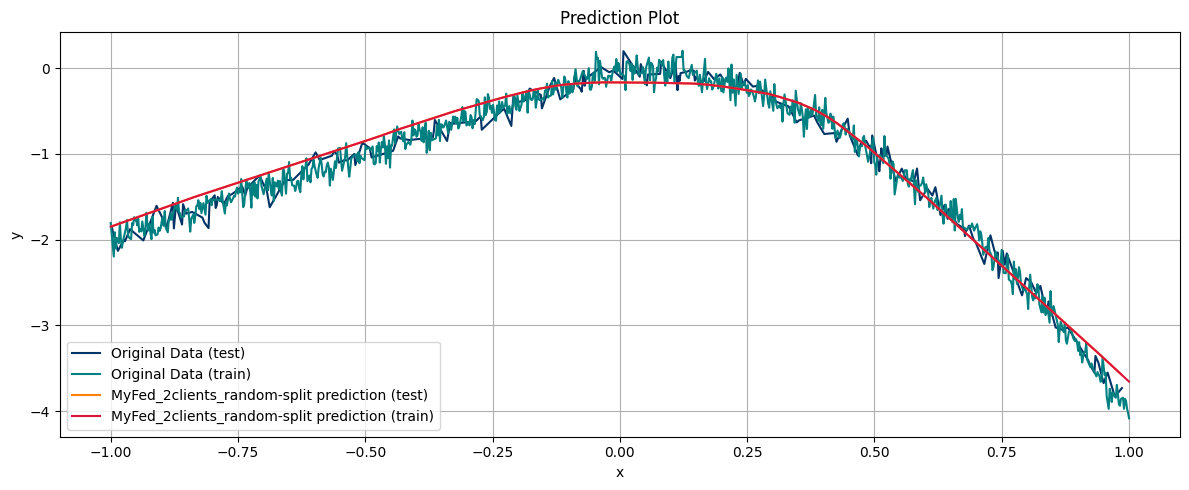

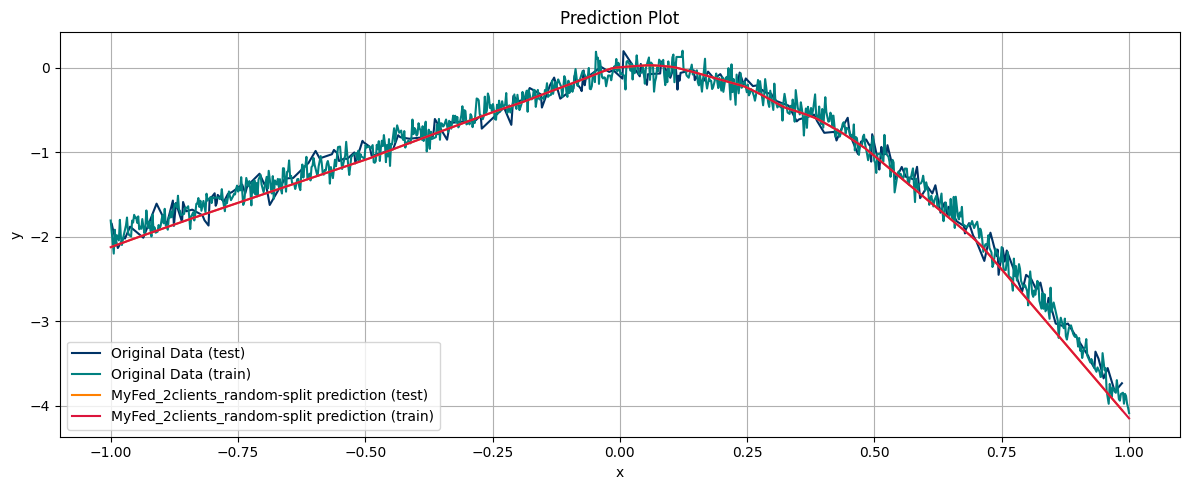

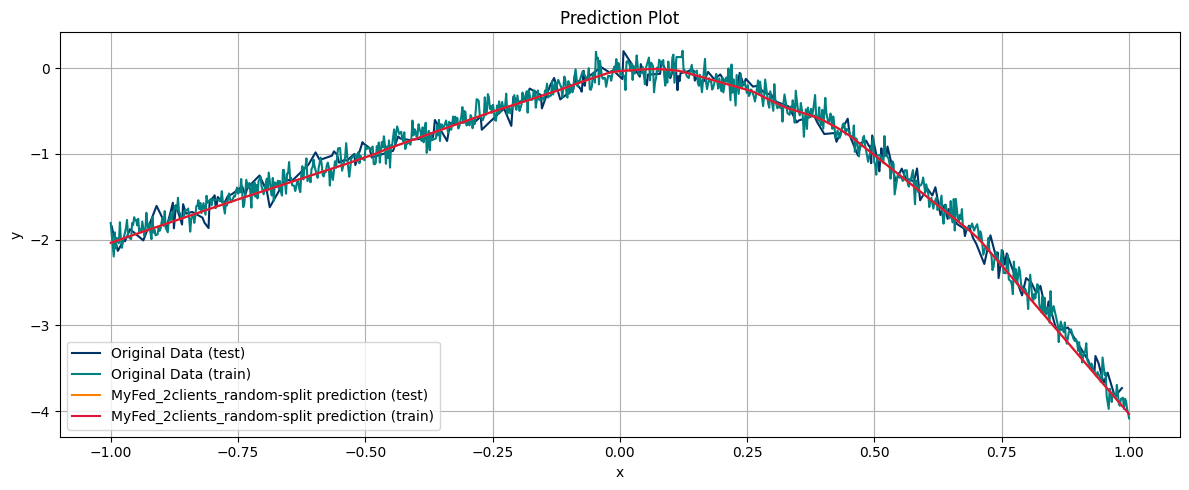

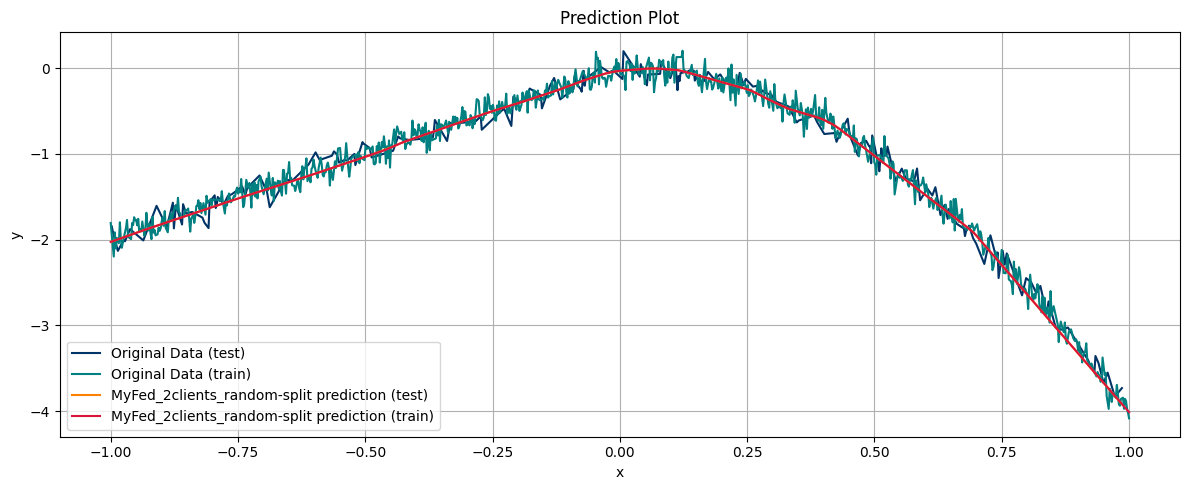

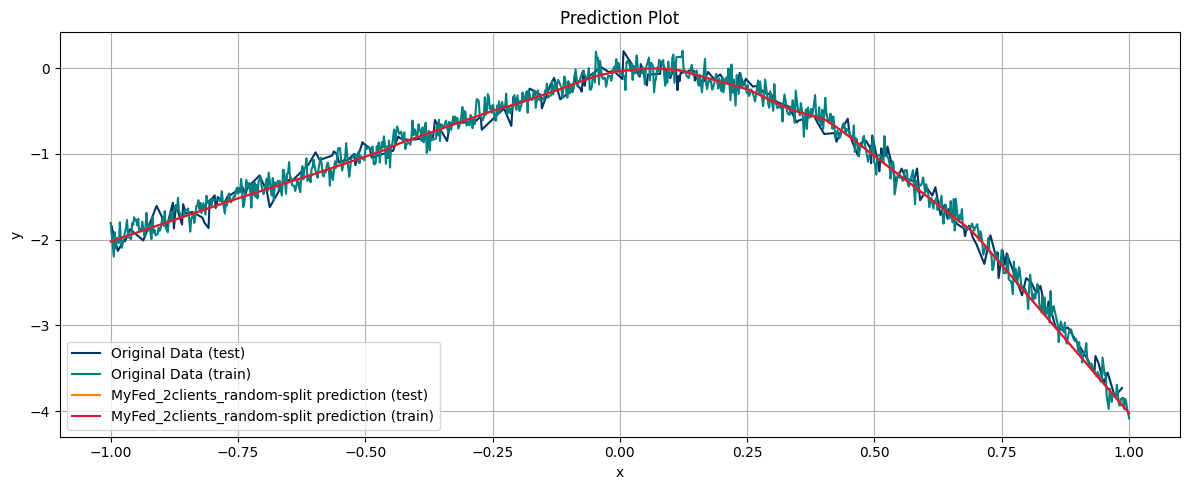

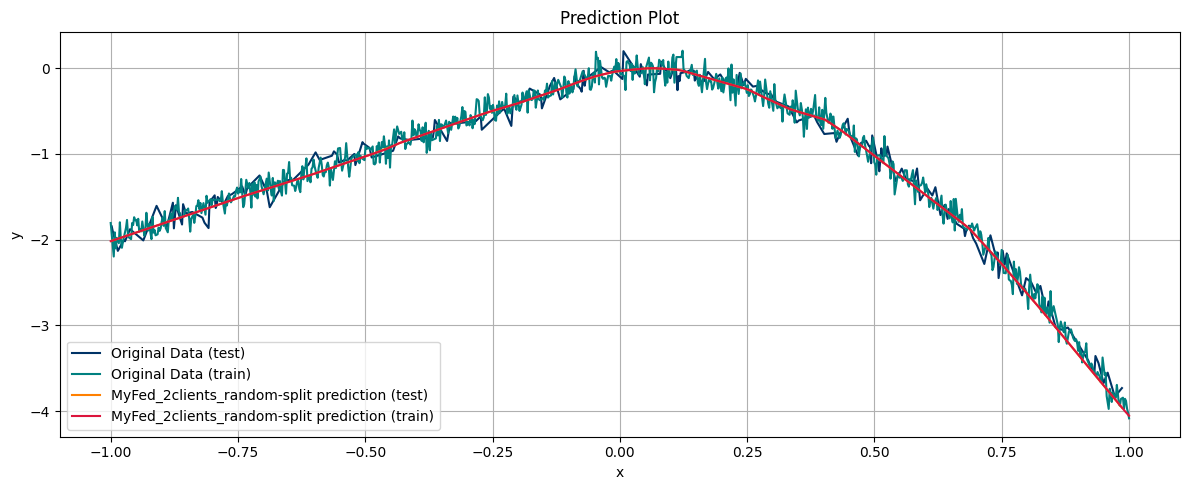

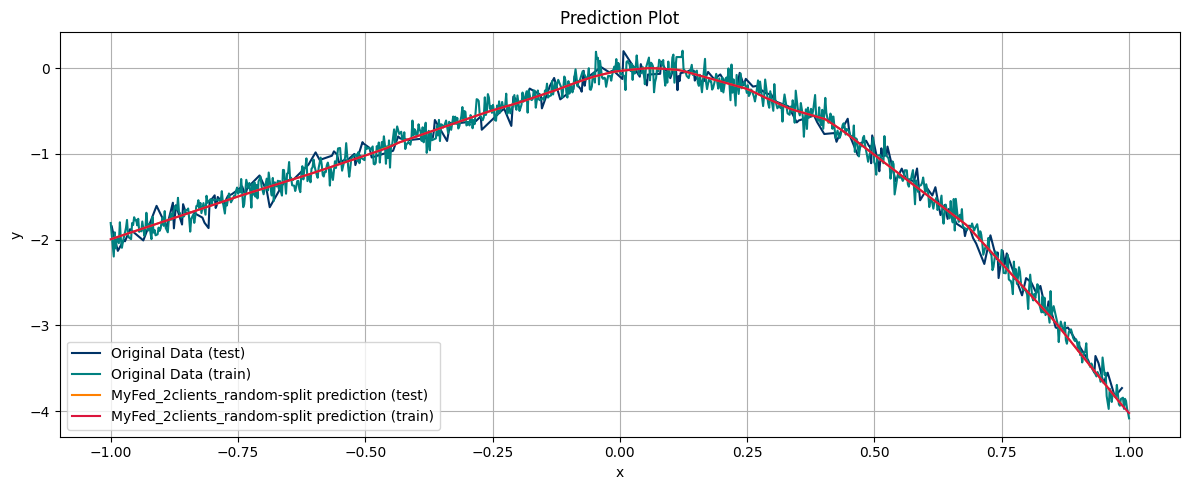

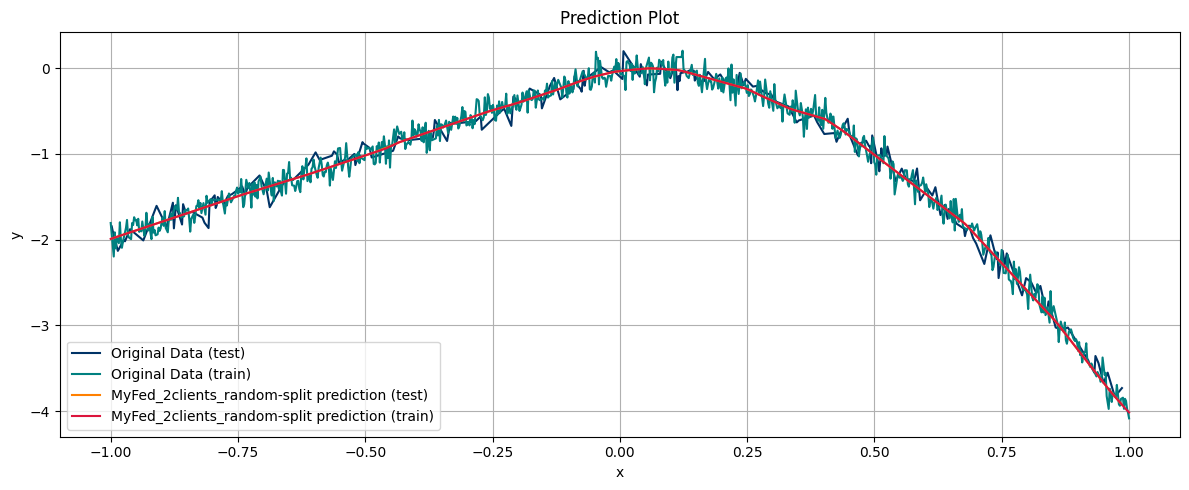

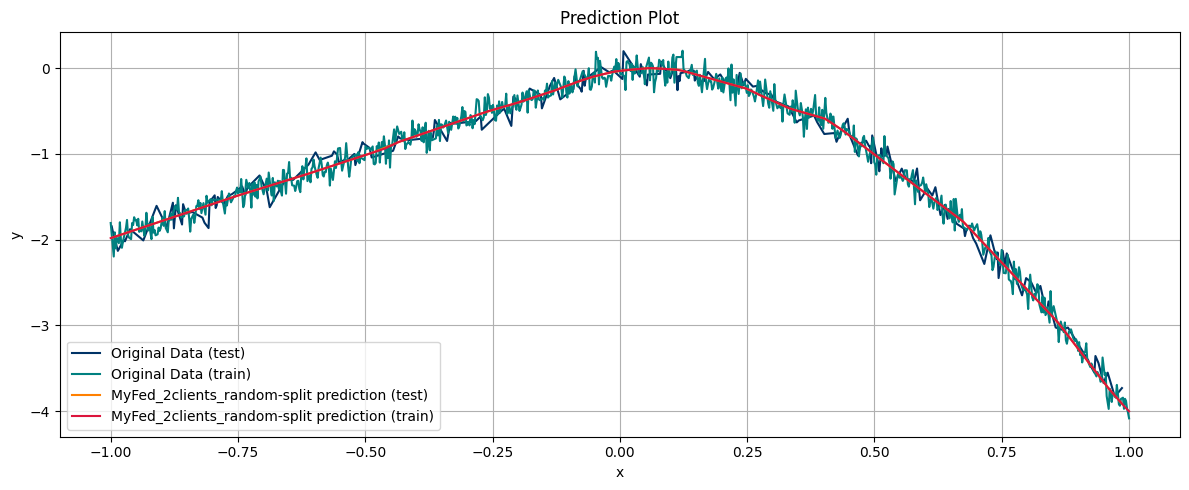

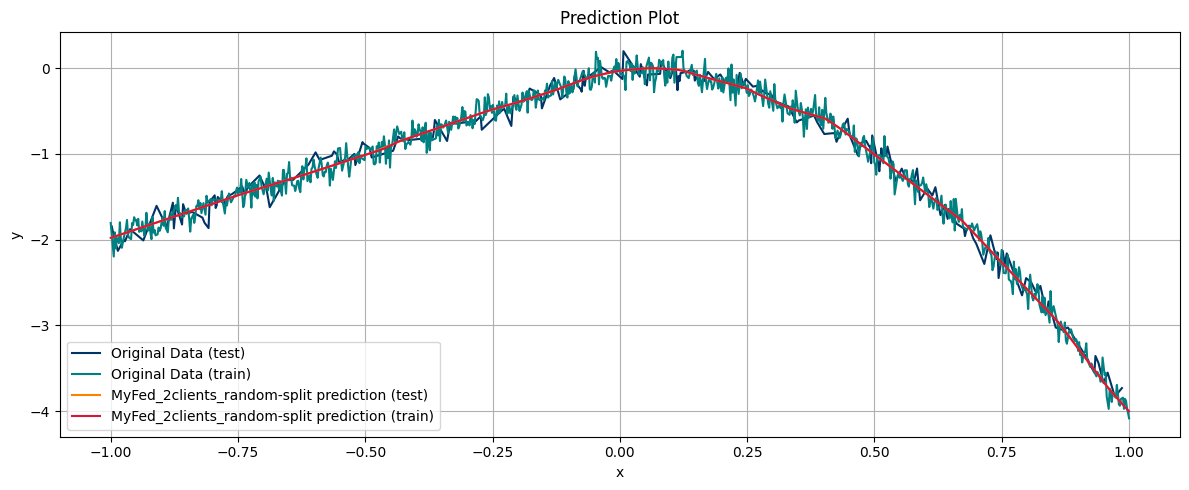

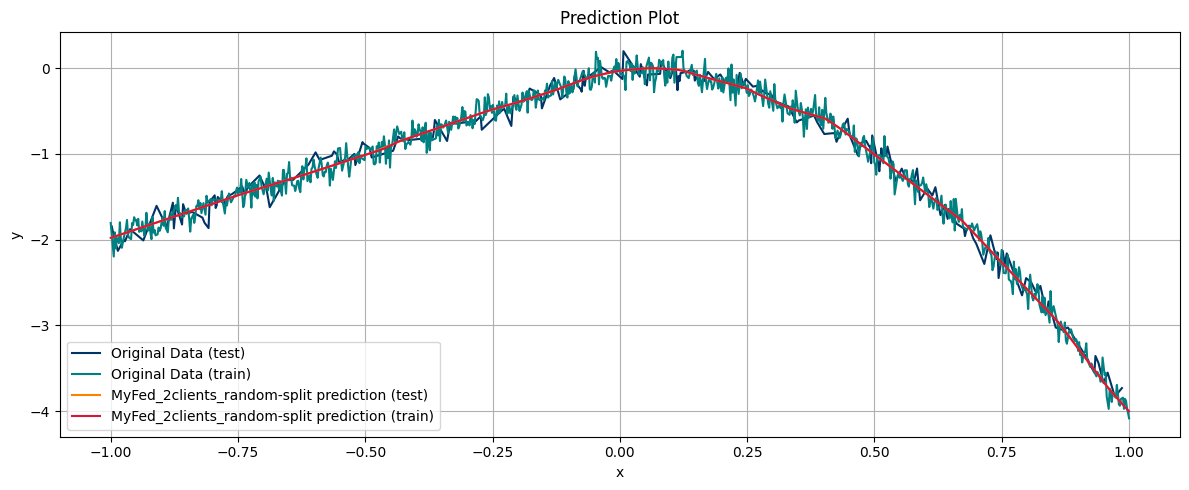

In [18]:
for cr in range(COMMUNICATION_ROUNDS):
    # train each client individually
    for client_no, client in zip(CLIENT_IDs, clients):
        train_client(
            client_no=client_no,
            client_model=client,
            data_loader=client_train_dataloaders[client_no],
            loss_fn=LOSS_FN,
            no_epochs=CLIENT_EPOCHS,
            communication_round=cr,
            writer=writer,
        )

    register_client_test_losses(
        clients=clients, client_ids=CLIENT_IDs, writer=writer, communication_round=cr
    )

    global_model = SmartAverageLayer.get_global_model(
        clients,
        similarity_threshold_in_degree=15,
    )

    writer.add_scalar("test_loss", evaluate(global_model), cr * CLIENT_EPOCHS)

    #### ----- Unimportant ----- NOTE: remove####################################################################################
    from IPython.display import clear_output

    clear_output(wait=True)
    print(f"Communication Round {cr}/{COMMUNICATION_ROUNDS}")
    print("\r global model: ", global_model, end="")
    # print("\n\n GLOBAL MODEL\n", list(global_model.named_parameters()))

    #### //// ----- Unimportant ------------------------------------------------------------------------------------------------

    clients = [
        global_model.get_client_model(
            client_id, add_noise=cr < COMMUNICATION_ROUNDS - 1
        )
        for client_id in CLIENT_IDs
    ]

    ###!!!!!!!!!!!!! NOTE:remove################################################################################################
    plot_predictions(global_model, model_name, writer, epoch=cr)
    # --------------------------------------------------------------------------------------------------------------------------

plot_predictions(global_model, model_name, writer)
register_hyperparameters(writer, last_loss=evaluate(global_model))
writer.close()

In [19]:
print(global_model.prediction_network.full_representation())
print(global_model.prediction_mask)

SelfLearningNet Weights: (training on output None)
Layer 0 Weights:
[[-0.7106987  -0.7034966 ]
 [-0.00962996 -0.9999509 ]
 [-0.7749412  -0.6320334 ]
 [-0.05379822 -0.9985068 ]
 [ 0.0565738   0.99839544]
 [-0.76213354 -0.6474199 ]
 [ 0.7033978  -0.71077776]
 [-0.7200824   0.69388866]
 [-0.82856107  0.5598988 ]
 [ 0.7268623  -0.6867801 ]
 [ 0.70933336 -0.7048695 ]
 [-0.37470618  0.9271431 ]
 [-0.2359241   0.9717563 ]
 [-0.9592693   0.2824933 ]
 [ 0.19953702  0.9798565 ]
 [ 0.97623223  0.21672699]]
Layer 1 Weights:
[[-3.68864208e-01 -9.45288762e-02  4.33725297e-01 -1.31388277e-01
   4.40348119e-01 -5.53682029e-01 -1.06321424e-01  1.52596906e-01
  -2.25240439e-02  3.90757248e-03  1.40404612e-01  1.41942680e-01
   2.08929926e-01 -4.34682779e-02  6.08336255e-02 -6.78032078e-03
   1.47194028e-01]
 [-4.97848988e-01  2.13125676e-01  2.42041051e-03  1.34934187e-01
  -2.85050929e-01 -1.75053149e-01 -3.39376569e-01 -7.79549628e-02
   3.16601731e-02  2.46907957e-02 -2.88119763e-01 -6.06082618e-01
 

In [20]:
for client in clients:
    print(client.prediction_network.full_representation())
    print(client.prediction_mask)

SelfLearningNet Weights: (training on output 0)
Layer 0 Weights:
[[-0.7106987  -0.7034966 ]
 [-0.00962996 -0.9999509 ]
 [-0.7749412  -0.6320334 ]
 [-0.05379822 -0.9985068 ]
 [ 0.0565738   0.99839544]
 [-0.76213354 -0.6474199 ]
 [ 0.7033978  -0.71077776]
 [-0.7200824   0.69388866]
 [-0.82856107  0.5598988 ]
 [ 0.7268623  -0.6867801 ]
 [ 0.70933336 -0.7048695 ]
 [-0.37470618  0.9271431 ]
 [-0.2359241   0.9717563 ]
 [-0.9592693   0.2824933 ]
 [ 0.19953702  0.9798565 ]
 [ 0.97623223  0.21672699]]
Layer 1 Weights:
[[-3.68864208e-01 -9.45288762e-02  4.33725297e-01 -1.31388277e-01
   4.40348119e-01 -5.53682029e-01 -1.06321424e-01  1.52596906e-01
  -2.25240439e-02  3.90757248e-03  1.40404612e-01  1.41942680e-01
   2.08929926e-01 -4.34682779e-02  6.08336255e-02 -6.78032078e-03
   1.47194028e-01]
 [-4.97848988e-01  2.13125676e-01  2.42041051e-03  1.34934187e-01
  -2.85050929e-01 -1.75053149e-01 -3.39376569e-01 -7.79549628e-02
   3.16601731e-02  2.46907957e-02 -2.88119763e-01 -6.06082618e-01
  -3